In [ ]:
# CELL 1: Cài đặt và Import thư viện
import pandas as pd
import numpy as np
import json
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
SRC_PATH = Path().resolve().parent / 'src'
sys.path.append(str(SRC_PATH))
import warnings
warnings.filterwarnings("ignore")

# Import các đường dẫn đã định nghĩa sẵn
from utils import DATA_DIR

# Cài đặt cấu hình cho plots
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'Segoe UI'
plt.rcParams['axes.unicode_minus'] = False



<Figure size 640x480 with 0 Axes>

In [2]:
# CELL 2: Định nghĩa bảng màu và đường dẫn
DATASET_COLORS = {
    'Train': "#a4c7fe", # Blue
    'Test': '#f59e0b',  # Amber
    'Silver': "#89c5b1" # Emerald
}
ENTITY_COLORS = {
    "Bệnh": "#ef4444",
    "Triệu chứng": "#3b82f6",
    "Nguyên nhân": "#f59e0b",
    "Chẩn đoán": "#10b981",
    "Điều trị": "#8b5cf6"
}
RELATION_COLORS = {
    'Gây_ra': '#ef4444',
    'Có_triệu_chứng': '#3b82f6',
    'Điều_trị_bằng': '#8b5cf6',
    'Chẩn_đoán_bằng': '#10b981',
    'No_relation': '#9ca3af'
}

# Đường dẫn tới các file dữ liệu đã qua xử lý
PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
TRAIN_JSON_PATH = os.path.join(PROCESSED_DIR, 'train_tasks.json')
TEST_JSON_PATH = os.path.join(PROCESSED_DIR, 'test_tasks.json')
TRAIN_CSV_PATH = os.path.join(PROCESSED_DIR, 'train_data.csv')
SILVER_CSV_PATH = os.path.join(PROCESSED_DIR, 'silver_data.csv')
TEST_CSV_PATH = os.path.join(PROCESSED_DIR, 'test_data.csv')

In [3]:
# CELL 3: Tải dữ liệu

try:
    with open(TRAIN_JSON_PATH, 'r', encoding='utf-8') as f:
        train_json_data = json.load(f)
    with open(TEST_JSON_PATH, 'r', encoding='utf-8') as f:
        test_json_data = json.load(f)
    
    df_train_re = pd.read_csv(TRAIN_CSV_PATH)
    df_test_re = pd.read_csv(TEST_CSV_PATH)
    
    if os.path.exists(SILVER_CSV_PATH):
        df_silver = pd.read_csv(SILVER_CSV_PATH)
    else:
        df_silver = pd.DataFrame()
        print(f"Cảnh báo: Không tìm thấy file dữ liệu Silver tại '{SILVER_CSV_PATH}'.")

except FileNotFoundError as e:
    print(f"Lỗi: Không tìm thấy file dữ liệu. Vui lòng chạy script preprocessing.py trước. Chi tiết: {e}")
    train_json_data, test_json_data, df_train_re, df_silver = [], [], pd.DataFrame(), pd.DataFrame()


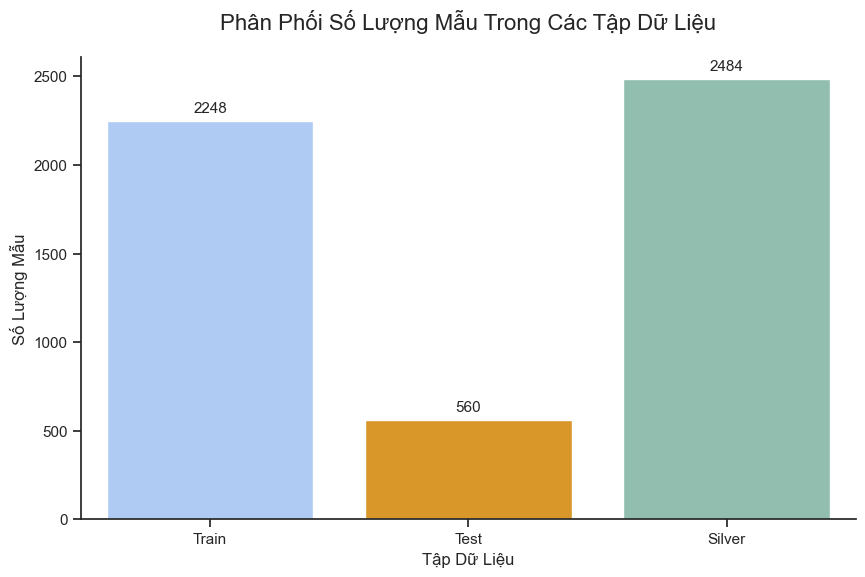

In [7]:
# CELL 4: Trực quan hóa kích thước các tập dữ liệu
dataset_sizes = {
    'Train': len(df_train_re),
    'Test': len(df_test_re),
    'Silver': len(df_silver)
}

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(dataset_sizes.keys()), y=list(dataset_sizes.values()), palette=DATASET_COLORS)
ax.set_title('Phân Phối Số Lượng Mẫu Trong Các Tập Dữ Liệu', fontsize=16, pad=20)
ax.set_xlabel('Tập Dữ Liệu', fontsize=12)
ax.set_ylabel('Số Lượng Mẫu', fontsize=12)

# Hiển thị số liệu trên mỗi cột
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=11)
sns.set_style("ticks")
sns.despine(top=True, right=True)
plt.show()

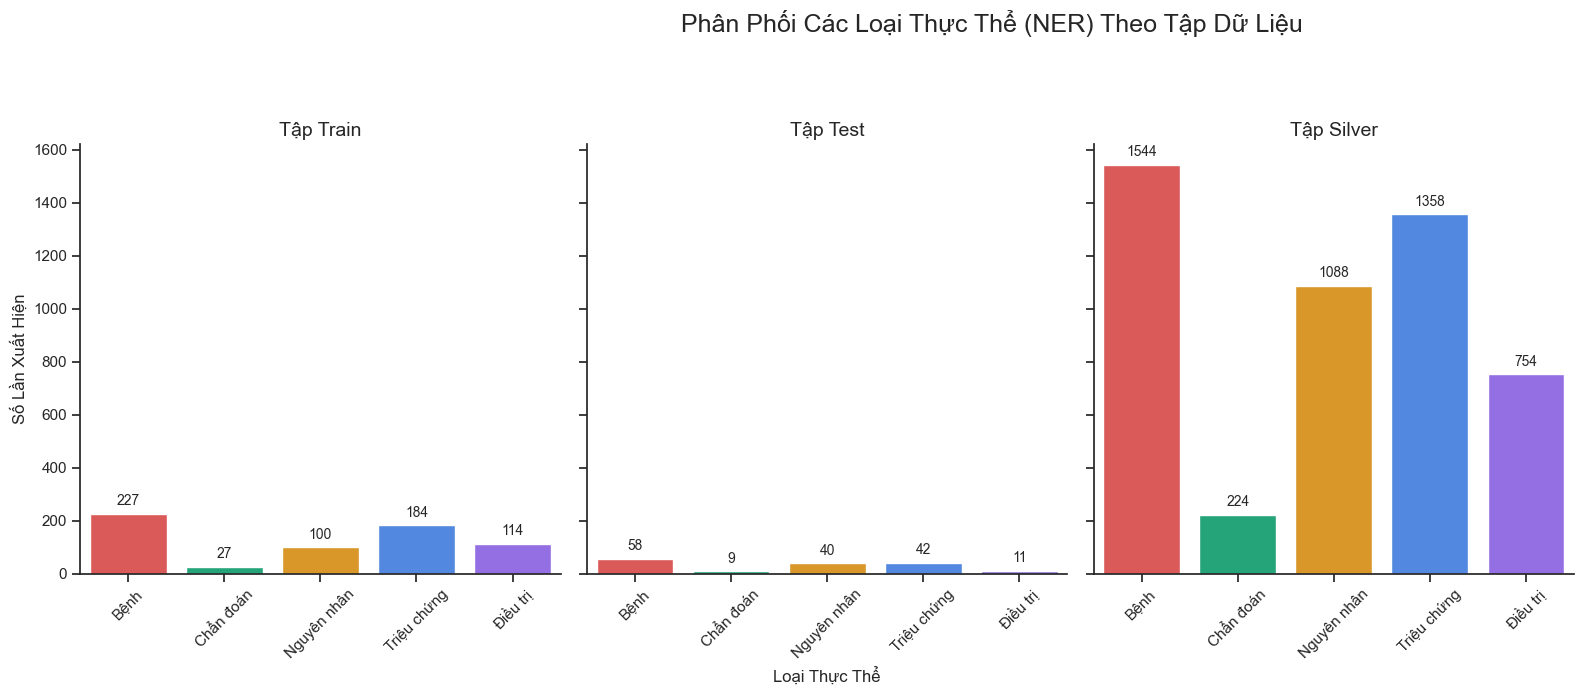

In [10]:
# CELL 5: Trực quan hóa phân phối các loại thực thể (NER)

# Helper Functions
def count_entities_from_json(json_data):
    """Đếm thực thể từ dữ liệu JSON của Label Studio."""
    counts = {}
    for task in json_data:
        if 'annotations' in task and task['annotations']:
            for result in task['annotations'][0]['result']:
                if result['type'] == 'labels':
                    label = result['value']['labels'][0]
                    counts[label] = counts.get(label, 0) + 1
    return pd.Series(counts).sort_index()

def count_entities_from_dataframe(df):
    """Đếm thực thể từ DataFrame (dùng cho tập Silver)."""
    if df.empty or 'subject_type' not in df.columns or 'object_type' not in df.columns:
        return pd.Series(dtype=int)
    
    # Gộp thực thể từ cả cột chủ thể và đối tượng, sau đó đếm
    all_entities = pd.concat([df['subject_type'], df['object_type']])
    return all_entities.value_counts().sort_index()

# Data Preparation
train_ent_counts = count_entities_from_json(train_json_data)
test_ent_counts = count_entities_from_json(test_json_data)
silver_ent_counts = count_entities_from_dataframe(df_silver)

# Visualization 
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
fig.suptitle('Phân Phối Các Loại Thực Thể (NER) Theo Tập Dữ Liệu', fontsize=18, y=1.02)

# Subplot 1: Tập Train
sns.barplot(ax=axes[0], x=train_ent_counts.index, y=train_ent_counts.values, palette=ENTITY_COLORS)
axes[0].set_title('Tập Train', fontsize=14)
axes[0].set_ylabel('Số Lần Xuất Hiện', fontsize=12)
axes[0].set_xlabel(None)
sns.set_style("ticks")
sns.despine(top=True, right=True)

# Subplot 2: Tập Test
sns.barplot(ax=axes[1], x=test_ent_counts.index, y=test_ent_counts.values, palette=ENTITY_COLORS)
axes[1].set_title('Tập Test', fontsize=14)
axes[1].set_xlabel('Loại Thực Thể', fontsize=12)
axes[1].set_ylabel(None)
sns.set_style("ticks")
sns.despine(top=True, right=True)

# Subplot 3: Tập Silver
if not silver_ent_counts.empty:
    sns.barplot(ax=axes[2], x=silver_ent_counts.index, y=silver_ent_counts.values, palette=ENTITY_COLORS)
axes[2].set_title('Tập Silver', fontsize=14)
axes[2].set_xlabel(None)
axes[2].set_ylabel(None)
sns.set_style("ticks")
sns.despine(top=True, right=True)

# Thêm số liệu lên trên các cột cho từng subplot
for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=10)

plt.tight_layout(rect=[0, 0.03, 0.8, 0.95])
plt.show()

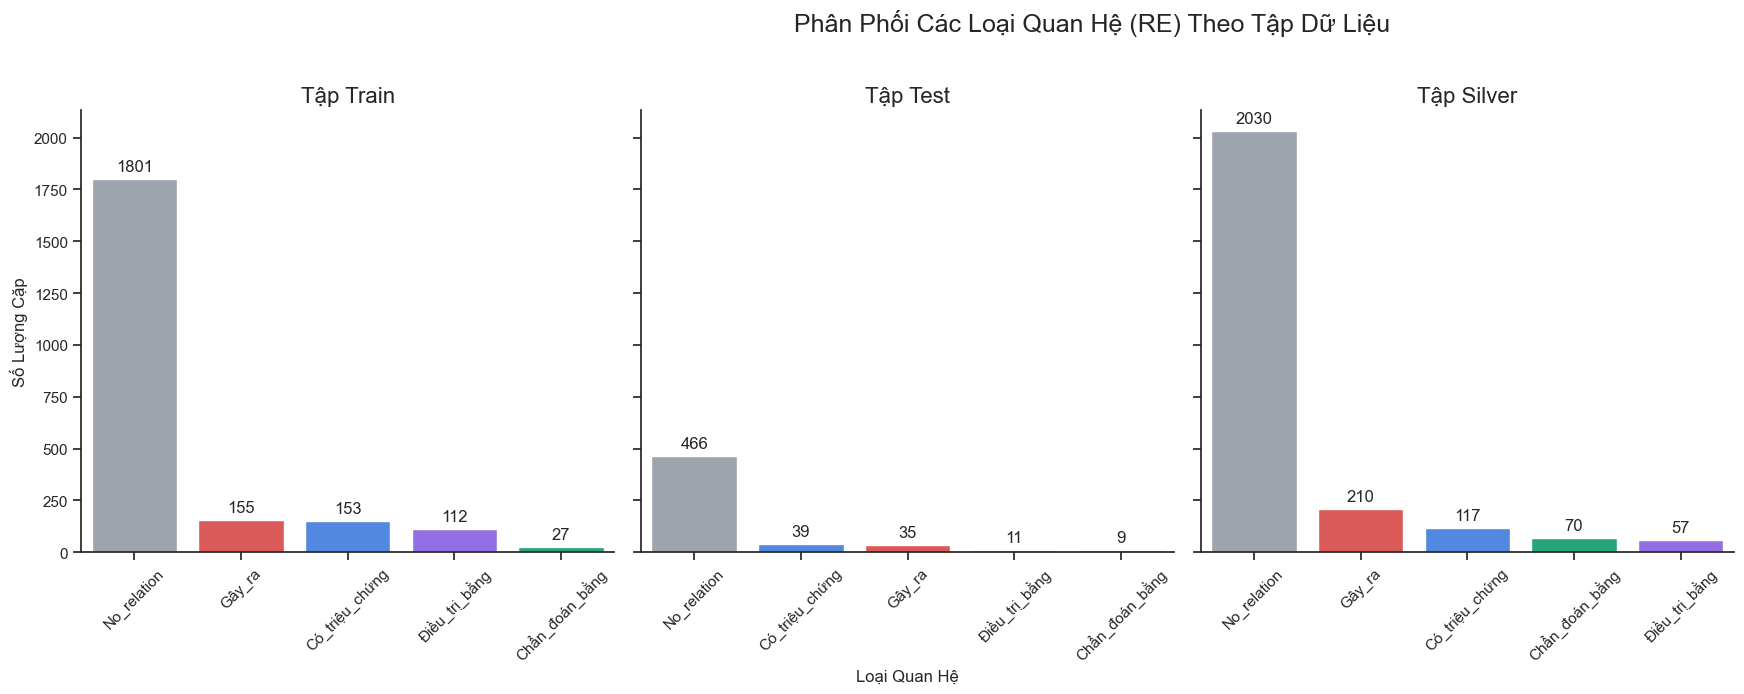

In [16]:
# CELL 6: Trực quan hóa phân phối các loại quan hệ (RE)

# Data Preparation
# Đếm số lượng quan hệ cho mỗi tập dữ liệu
train_rel_counts = df_train_re['relation_label'].value_counts()
test_rel_counts = df_test_re['relation_label'].value_counts()
if not df_silver.empty:
    silver_rel_counts = df_silver['relation_label'].value_counts()
else:
    silver_rel_counts = pd.Series()

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(22, 7), sharey=True)
fig.suptitle('Phân Phối Các Loại Quan Hệ (RE) Theo Tập Dữ Liệu', fontsize=18, y=1.02)

# Subplot 1: Tập Train
sns.barplot(ax=axes[0], x=train_rel_counts.index, y=train_rel_counts.values, palette=RELATION_COLORS)
axes[0].set_title('Tập Train', fontsize=16)
axes[0].set_ylabel('Số Lượng Cặp', fontsize=12)
axes[0].set_xlabel(None)
sns.set_style("ticks")
sns.despine(top=True, right=True)

# Subplot 2: Tập Test
sns.barplot(ax=axes[1], x=test_rel_counts.index, y=test_rel_counts.values, palette=RELATION_COLORS)
axes[1].set_title('Tập Test', fontsize=16)
axes[1].set_xlabel('Loại Quan Hệ', fontsize=12)
axes[1].set_ylabel(None)
sns.set_style("ticks")
sns.despine(top=True, right=True)

# Subplot 3: Tập Silver
if not silver_rel_counts.empty:
    sns.barplot(ax=axes[2], x=silver_rel_counts.index, y=silver_rel_counts.values, palette=RELATION_COLORS)
axes[2].set_title('Tập Silver', fontsize=16)
axes[2].set_xlabel(None)
axes[2].set_ylabel(None)
sns.set_style("ticks")
sns.despine(top=True, right=True)

# Thêm số liệu và xoay nhãn
for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=12)

plt.tight_layout(rect=[0, 0.03, 0.8, 1])
plt.show()